# The Taxi Problem

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from time import sleep
import warnings

warnings.filterwarnings("ignore")

Function to run animation

In [2]:
def run_animation(experience_buffer):
    time_lag = 0.05  # Delay (in s) between frames
    for experience in experience_buffer:
        # Plot frame
        clear_output(wait=True)
        plt.imshow(experience['frame'])
        plt.axis('off')
        plt.show()

        print(f"Episode: {experience['episode']}/{experience_buffer[-1]['episode']}")
        print(f"Epoch: {experience['epoch']}/{experience_buffer[-1]['epoch']}")
        print(f"State: {experience['state']}")
        print(f"Action: {experience['action']}")
        print(f"Reward: {experience['reward']}")

        # Pause animation
        sleep(time_lag)

Environment initialization

State space: Discrete(500)
Action space: Discrete(6)
State: 202
Action: 0
Action mask: [1 1 1 0 0 0]
Reward: -1


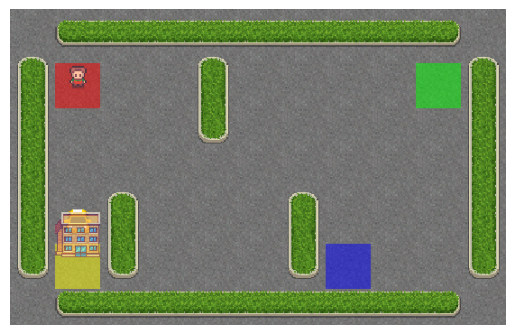

In [3]:
# Initialize and validate the environment
env = gym.make("Taxi-v3", render_mode="rgb_array").env
state, _ = env.reset()

# Print dimensions of state and action space
print(f"State space: {env.observation_space}")
print(f"Action space: {env.action_space}")

# Sample random action
action = env.action_space.sample(env.action_mask(state))
next_state, reward, done, _, _ = env.step(action)

print(f"State: {state}")
print(f"Action: {action}")
print(f"Action mask: {env.action_mask(state)}")
print(f"Reward: {reward}")

# Render and plot an environment frame
frame = env.render()
plt.imshow(frame)
plt.axis("off")
plt.show()

Training the agent

In [4]:
q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Hyperparameters
alpha = 0.1  # Learning rate
gamma = 1.0  # Discount rate
epsilon = 0.1  # Exploration rate
num_episodes = 10000  # Number of episodes

cum_rewards = np.zeros([num_episodes])
total_epochs = np.zeros([num_episodes])

for episode in range(1, num_episodes+1):
    state, info = env.reset()
    epoch = 0
    num_failed_dropoffs = 0
    done = False
    cum_reward = 0

    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample(env.action_mask(state)) # "Explore action space with action mask"
        else:
            action_mask = np.where(info["action_mask"]==1,0,1) # invert
            masked_q_values = np.ma.array(q_table[state], mask=action_mask, dtype=np.float32)
            action = np.ma.argmax(masked_q_values, axis=0) # "Exploit learned values with action mask"
        
        next_state, reward, done, _ , info = env.step(action)

        cum_reward += reward

        old_q_value = q_table[state, action]
        next_max = np.max(q_table[next_state])

        new_q_value = (1 - alpha) * old_q_value + alpha * (reward + gamma * next_max)

        q_table[state, action] = new_q_value

        if reward == -10:
            num_failed_dropoffs += 1

        state = next_state
        epoch += 1

        total_epochs[episode-1] = epoch
        cum_rewards[episode-1] = cum_reward

    if episode % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {episode}")

print("Training completed.")

Episode: 10000
Training completed.


Performance test
(Test policy performance after training)

In [5]:
num_epochs = 0
total_failed_deliveries = 0
num_episodes = 20
experience_buffer = []
total_penalties = 0

for episode in range(1, num_episodes + 1):
    # Initialize experience buffer
    my_env = env.reset()
    state = my_env[0]
    epoch = 1 
    num_failed_deliveries =0
    cum_reward = 0
    done = False
    num_of_penalty = 0

    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, _, _ = env.step(action)
        cum_reward += reward
        
        if reward <= 0:
            num_of_penalty += 1

        if reward == -10:
            num_failed_deliveries += 1

        # Store rendered frame in animation dictionary
        experience_buffer.append({
            'frame': env.render(),
            'episode': episode,
            'epoch': epoch,
            'state': state,
            'action': action,
            'reward': cum_reward
            }
        )

        epoch += 1

    total_failed_deliveries += num_failed_deliveries
    num_epochs += epoch
    total_penalties += num_of_penalty

# Run animation and print output
# run_animation(experience_buffer)

print(f"Test results after {num_episodes} episodes and epsilon = {epsilon}:\n")
print(f"Mean epochs per episode: {num_epochs / num_episodes}")
print(f"Mean failed drop-offs per episode: {total_failed_deliveries / num_episodes}")
print(f"Mean number of penalties per episode: {total_penalties / num_episodes}")

Test results after 20 episodes and epsilon = 0.1:

Mean epochs per episode: 14.55
Mean failed drop-offs per episode: 0.0
Mean number of penalties per episode: 12.55
